In [1]:
modelName = 'densenet161'
filterName = 'None'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os, sys

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = models.densenet161(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=80, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=20, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.019392392160131378 | Val loss: 0.007714177956475226
Epoch: 2 / 15 | Train loss: 0.00796051540447944 | Val loss: 0.004696575430035816
Epoch: 3 / 15 | Train loss: 0.0063734041105142055 | Val loss: 0.005647803463464396
Epoch: 4 / 15 | Train loss: 0.006022432424235487 | Val loss: 0.004068940306974012
Epoch: 5 / 15 | Train loss: 0.0045676146298620724 | Val loss: 0.004997743854230967
Epoch: 6 / 15 | Train loss: 0.0036148855003793694 | Val loss: 0.0045048071879370795
Epoch: 7 / 15 | Train loss: 0.003372481204441601 | Val loss: 0.004780044546608186
Epoch: 8 / 15 | Train loss: 0.002942138872234004 | Val loss: 0.008584154363248742
Epoch: 9 / 15 | Train loss: 0.003207293737180837 | Val loss: 0.0044927932317989595
Epoch: 10 / 15 | Train loss: 0.0029685758215450483 | Val loss: 0.005001069834348977
Epoch: 11 / 15 | Train loss: 0.0025761216181989944 | Val loss: 0.0040197744828339484
Epoch: 12 / 15 | Train loss: 0.0020424798911399867 | Val loss: 0.004740627431806461
Epoch

12


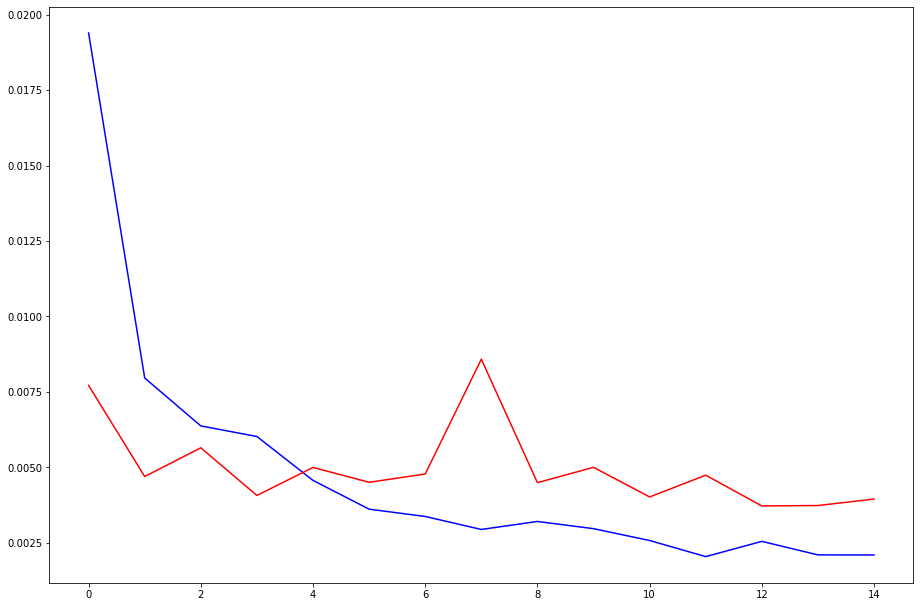

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = models.densenet161(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=20, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 23min 28s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)

In [17]:
predict_df

filename        model filter   point  v  \
0       3173d177-d487-448e-be42-68c86b8d7ab5  densenet161   None  Point1  0   
1       64fb7418-ba16-47bd-ba92-ed0dff078cd6  densenet161   None  Point1  0   
2       2db8082b-429f-4855-9f83-7ec846d19c61  densenet161   None  Point1  0   
3       0b2b33e0-1d35-4cea-bf4c-1e8c2fb274f7  densenet161   None  Point1  0   
4       7b6fabbd-d850-4b04-ab4f-637fb58ac761  densenet161   None  Point1  0   
...                                      ...          ...    ...     ... ..   
528315  a291820b-92ec-42c7-8e19-8631228fa5e1  densenet161   None  Point1  3   
528316  845f9034-012d-4f4f-9986-6ed293c84ab8  densenet161   None  Point1  3   
528317  9eda6aad-3216-4556-bdb9-baef04d6f115  densenet161   None  Point1  3   
528318  74ad5c1c-6340-43a3-bc97-3fde33084f6b  densenet161   None  Point1  3   
528319  9f0eb08b-9e0b-47fc-bb76-e31362639a9a  densenet161   None  Point1  3   

         predict  sign  
0       0.000096  -1.0  
1       0.000117   0.0  
2       0.000083  -1.0  
3       0.000049  -1.0  
4       0.000102  -1.0  
...          ...   ...  
528315  0.000151   0.0  
528316  0.000094  -1.0  
528317  0.000066  -1.0  
528318  0.000095  -1.0  
528319  0.000107  -1.0  

[528320 rows x 7 columns]

In [18]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [19]:
modelName = 'densenet161'
filterName = 'None'
point = 'Point2'

pointLoad = 'Point1'

In [20]:
model = models.densenet161(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{pointLoad}.pt'))


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [21]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 10
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=80, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=20, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 10 | Train loss: 0.001936525600774055 | Val loss: 0.0031701090515920518
Epoch: 2 / 10 | Train loss: 0.001360902151856418 | Val loss: 0.003051193607844854
Epoch: 3 / 10 | Train loss: 0.0010431628419656997 | Val loss: 0.003011578060445382
Epoch: 4 / 10 | Train loss: 0.0009075170016251998 | Val loss: 0.00306598794494386
Epoch: 5 / 10 | Train loss: 0.0009269175337438683 | Val loss: 0.0029665105877552888
Epoch: 6 / 10 | Train loss: 0.0006824183691345594 | Val loss: 0.0030453796574453898
Epoch: 7 / 10 | Train loss: 0.0007779710047023084 | Val loss: 0.003051431830060833
Epoch: 8 / 10 | Train loss: 0.0007230670153821438 | Val loss: 0.002937028887651483
Epoch: 9 / 10 | Train loss: 0.0006628627495757747 | Val loss: 0.002954650244479781
Epoch: 10 / 10 | Train loss: 0.0007590249946196429 | Val loss: 0.0029091040625433824
Wall time: 30min 33s


9


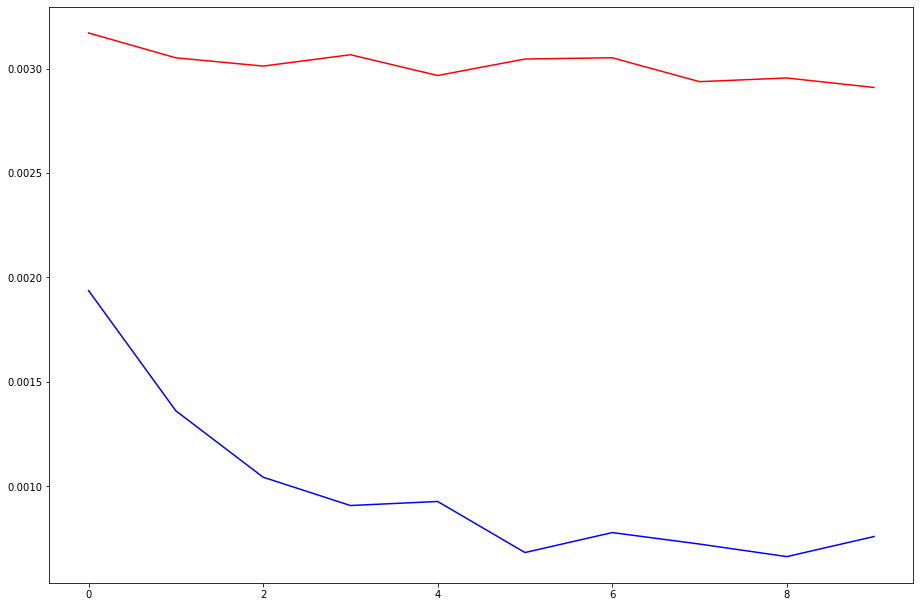

In [22]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [23]:
model = models.densenet161(pretrained=True)

model.classifier = torch.nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [24]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(61),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=20, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 22min 15s


In [25]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [26]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model filter   point  v  \
0       a2410f78-8bb7-40bc-b57b-75ede79a3dd2  densenet161   None  Point2  0   
1       fe0843d4-915b-49e5-8986-b26ee7d431e3  densenet161   None  Point2  0   
2       c4444b84-6b5c-4504-bf77-40bb48bae1f4  densenet161   None  Point2  0   
3       49342189-2010-415e-8588-4281be897dfa  densenet161   None  Point2  0   
4       a2516a3e-050d-44a1-a0d6-7e14880b9c3a  densenet161   None  Point2  0   
...                                      ...          ...    ...     ... ..   
528315  0b2348b8-0141-470f-9241-cc77491abdbe  densenet161   None  Point2  3   
528316  24e00702-d4c0-45c2-b39d-09937617256b  densenet161   None  Point2  3   
528317  fd5900ff-fc82-4f10-b6c9-ec692dc4d175  densenet161   None  Point2  3   
528318  955e7318-6fa1-4870-a537-452e34cf3469  densenet161   None  Point2  3   
528319  26aed5fa-409f-4025-b584-f51275080783  densenet161   None  Point2  3   

         predict  sign  
0       0.000053  -1.0  
1       0.000046  -1.0  
2       0.000056  -1.0  
3       0.000062   0.0  
4       0.000044  -1.0  
...          ...   ...  
528315  0.000046  -1.0  
528316  0.000053  -1.0  
528317  0.000007   0.0  
528318  0.000062  -1.0  
528319  0.000061  -1.0  

[528320 rows x 7 columns]

In [27]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)